<a href="https://colab.research.google.com/github/ChoiDae1/2022_CVLAB_Winter_Study/blob/main/PyTorch/Image%20and%20Video/Adversarial_Example_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Adversarial Machine Learning

For context, there are many categories of adversarial attacks, each with a different goal and assumption of the attacker’s knowledge. However, in general the overarching goal is to add the least amount of perturbation to the input data to cause the desired misclassification.

Several kinds of **assumptions of the attacker’s knowledge**

1. **white-box**: Assuming the attacker has full knowledge and access to the model, including architecture, inputs, outputs, and weights. 
2. **black-box**: Assuming the attacker only has access to the inputs and outputs of the model, and knows nothing about the underlying architecture or weights. 

There are also **several types of goals**
1. **misclassification**: Meaning the adversary only wants the output classification to be wrong but does not care what the new classification is. 
2. **Source/target misclassification**: Meaning the adversary wants to alter an image that is originally of a specific source class so that it is classified as a specific target class.

## Fast Gradient Sign Attack

The FGSM attack is a white-box attack with the goal of misclassification. With this background information, we can now discuss the attack in detail.
This attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

### Inputs

In [26]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

### Model Under Attack

In [3]:
#MNIST Train dataset and dataloader 

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=24, shuffle=True)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [20]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [21]:
# Load the pretrained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
model = Net().to(device)

loss_func = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [23]:
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for images, labels  in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # backprop & gradient step
        optimizer.zero_grad()
        pred = model(images)
        loss = loss_func(pred, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'At epoch {epoch+1}: Avg loss is {total_loss/len(train_loader.dataset): > 6.4f}')
    print()

At epoch 1: Avg loss is  0.5020

At epoch 2: Avg loss is  0.2604

At epoch 3: Avg loss is  0.2140

At epoch 4: Avg loss is  0.1859

At epoch 5: Avg loss is  0.1671

At epoch 6: Avg loss is  0.1588

At epoch 7: Avg loss is  0.1538

At epoch 8: Avg loss is  0.1451

At epoch 9: Avg loss is  0.1355

At epoch 10: Avg loss is  0.1320



In [24]:
with torch.no_grad():
    model.eval()
    total_loss = 0.0
    total_pred_true = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        loss = loss_func(pred, labels)
      
        batch_pred_true = (torch.argmax(pred, dim=1) == labels).sum()
        total_loss += loss.item()
        total_pred_true += batch_pred_true
  
print(f'Total Avg loss:{total_loss/len(test_loader.dataset): > 6.4f}')
print(f'Total Accuracy:{(total_pred_true/len(test_loader.dataset))*100: > 6.2f}%')


Total Avg loss: 0.0379
Total Accuracy: 98.78%


In [27]:
torch.save(model.state_dict(), pretrained_model)

In [28]:
# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## FGSM Attack

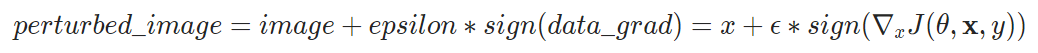

In [31]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # Adding clipping to maintain [0,1] range
    return perturbed_image

## Testing Function

In [35]:
def test( model, device, test_loader, epsilon ):
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)

        model.zero_grad()
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Run Attack

In [36]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9878 / 10000 = 0.9878
Epsilon: 0.05	Test Accuracy = 9411 / 10000 = 0.9411
Epsilon: 0.1	Test Accuracy = 8319 / 10000 = 0.8319
Epsilon: 0.15	Test Accuracy = 6178 / 10000 = 0.6178
Epsilon: 0.2	Test Accuracy = 4002 / 10000 = 0.4002
Epsilon: 0.25	Test Accuracy = 2476 / 10000 = 0.2476
Epsilon: 0.3	Test Accuracy = 1549 / 10000 = 0.1549


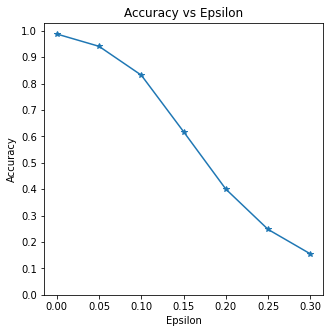

In [37]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

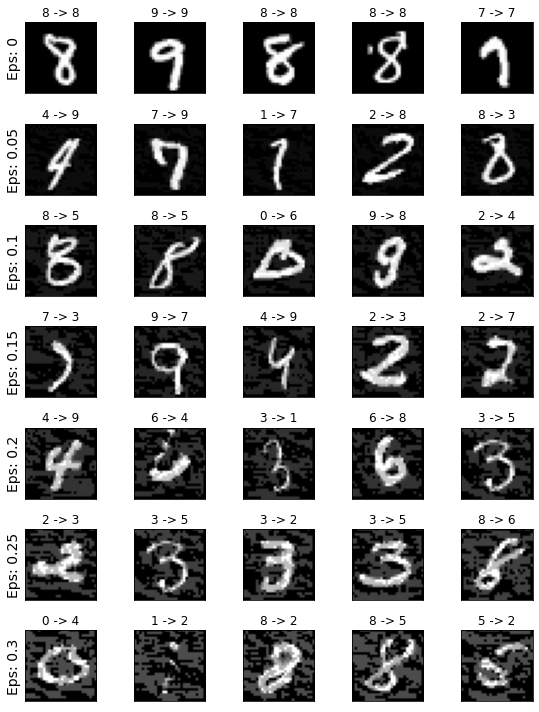

In [38]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()